In [1]:
# Thoomas Goldman 2023
# DOLPHINN

import sys
import os
import matplotlib.pyplot as plt

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.dynamics import TwoBodyProblemRadialNonDimensionalControl
from DOLPHINN.output_layers import InitialFinalStateLayer_Radial
from DOLPHINN.training import Scheduler, Restarter
from DOLPHINN.objectives import OptimalFuel
import DOLPHINN.plotting as plotting
from DOLPHINN import utils

import numpy as np

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10
umax = 10
isp = 2500

rp = AU
ra = 1.5*AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(mu/r0)
initial_state = np.array([r0, vr0, vt0])

# Final state
rfinal = 1.5*AU
vr_final = 0
vt_final = np.sqrt(mu/rfinal)
final_state = np.array([rfinal, vr_final, vt_final])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

final_state[:1] = final_state[:1]/length_scale
final_state[1:] = final_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 0.5*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 5
neurons = 5
hidden_layers = 3
layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension]

data = {"initial_state": initial_state,
        "final_state": final_state,
        "mu": mu,
        "m": m,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

In [3]:
# Create problem
problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensionalControl",
                    output_transform = "InitialFinalStateLayer_Radial",
                    objective = "OptimalFuel")

restarter = Restarter(loss_weigths = [1, 1, 1, 1e-6])
#schedule = Scheduler([(1e-3, 2000)], loss_weigths = [1, 1, 1, 1e-7])
problem.train(restarter)

[DOLPHINN] Using time-dependent random seed: 20230630181751

[DOLPHINN] Training with procedure: Restarter

Initialisation attempt: 1
Compiling model...
'compile' took 0.003191 s

Training model...

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Step      Train loss                                  Test loss                                   Test metric
0         [6.34e+00, 2.71e+02, 5.88e+01, 4.80e-03]    [5.45e+00, 2.65e+02, 5.42e+01, 4.76e-03]    []  
1000      [1.64e-01, 2.06e-02, 1.12e-02, 5.54e-05]    [1.21e-01, 2.10e-02, 1.08e-02, 4.92e-05]    []  
2000      [5.46e-02, 4.63e-03, 1.75e-03, 2.67e-05]    [4.50e-02, 4.70e-03, 1.70e-03, 2.38e-05]    []  
3000      [2.38e-02, 1.79e-03, 3.75e-04, 1.76e-05]    [2.11e-02, 1.82e-03, 3.71e-04, 1.60e-05]    []  

Best model at step 3000:
  train loss: 2.60e-02
  test loss: 2.33e-02
  test 

In [7]:
schedule = Scheduler([(5e-2, 4000), (1e-4, 10000)],
                     loss_weigths= [1, 1, 1, 1e-6]
                    )
problem.train(schedule)


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.097534 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
17000     [3.48e-07, 8.24e-08, 6.35e-07, 1.89e-05]    [3.48e-07, 8.27e-08, 4.80e-07, 1.64e-05]    []  
18000     [4.77e-03, 6.90e-04, 1.93e-04, 2.09e-05]    [4.47e-03, 6.98e-04, 1.92e-04, 1.95e-05]    []  
19000     [1.09e-03, 9.96e-05, 2.26e-05, 1.93e-05]    [1.05e-03, 9.61e-05, 2.18e-05, 1.77e-05]    []  
20000     [4.41e-04, 2.39e-05, 7.47e-06, 1.92e-05]    [4.26e-04, 2.29e-05, 7.08e-06, 1.80e-05]    []  
21000     [1.68e-04, 1.87e-05, 3.88e-06, 1.85e-05]    [1.62e-04, 1.87e-05, 3.86e-06, 1.74e-05]    []  

Best model at step 16000:
  train loss: 1.99e-05
  test loss: 1.73e-05
  test metric: []

'train' took 16.982659 s

Compiling model...
'compile' took 0.103279 s

Training model...

Step      Train loss                                  Test loss                 

In [8]:
utils.print_config(problem.config)


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl
input_transform                NoneType
output_transform               InitialFinalStateLayer_Radial
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           10
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfinal                         4.390509206900453

----------Network----------
architecture                   [1, [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], 5]
activation                     sin
sampler                        perturb

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 1.116 s


(<Figure size 1200x700 with 8 Axes>,
 array([[<Axes: ylabel='$x_1$'>, <Axes: ylabel='$u_1$'>],
        [<Axes: ylabel='$x_2$'>,
         <Axes: xlabel='Time [-]', ylabel='$u_2$'>],
        [<Axes: ylabel='$x_3$'>, <Axes: >],
        [<Axes: xlabel='Time [-]', ylabel='$x_4$'>, <Axes: >]],
       dtype=object))

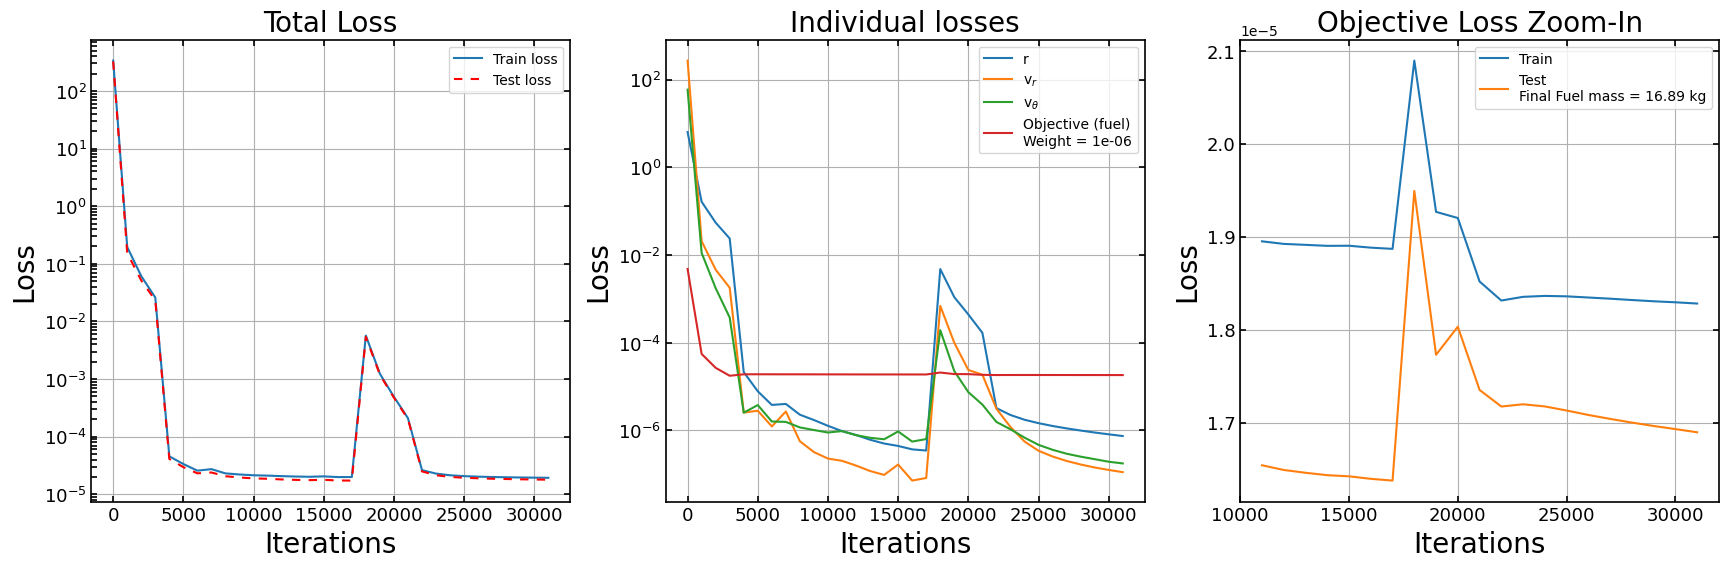

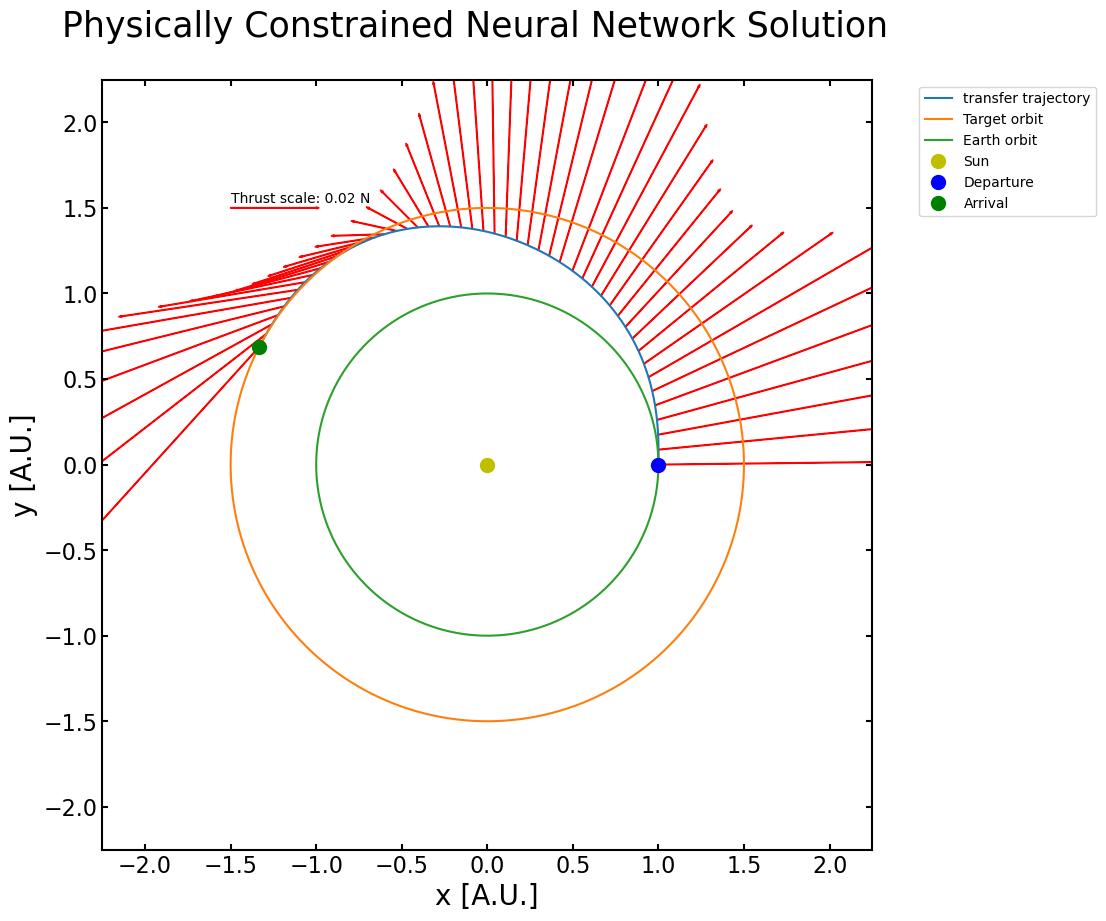

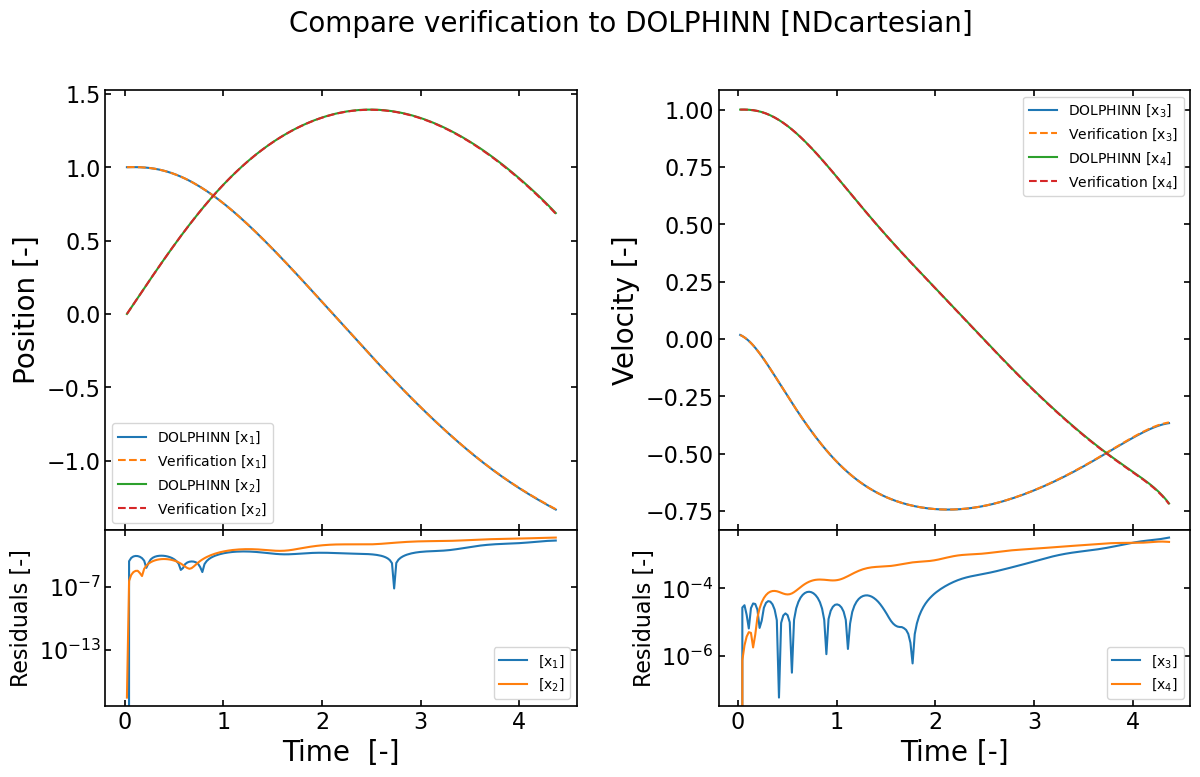

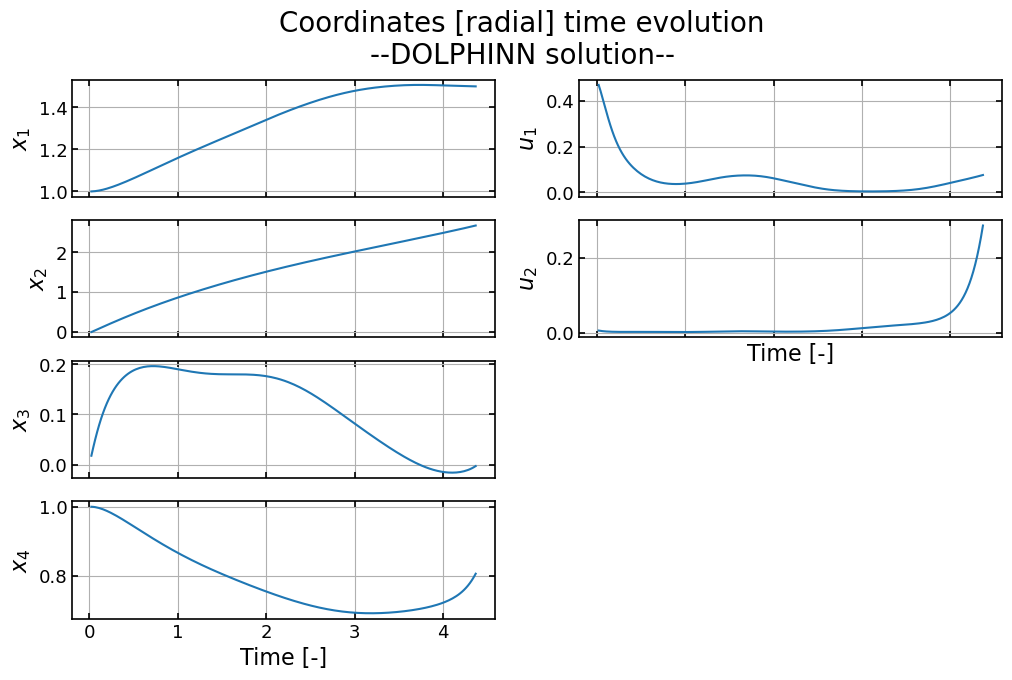

In [9]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=True)  
plotting.plot_transfer(problem)
plotting.compare(problem, 'NDcartesian')
plotting.plot_coordinates(problem, "radial")

In [10]:
problem.store("../Data/test3/", overwrite = False)

Saving loss history to ../Data/test3/loss.dat ...
Saving training data to ../Data/test3/train.dat ...
Saving test data to ../Data/test3/test.dat ...
[DOLPHINN] Saving config file to ../Data/test3/config
